# Python imports

In [1]:
import json
import http.client
from urllib.parse import urlencode, quote_plus, quote
import pandas as pd
from datetime import datetime
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from tslearn.utils import to_time_series_dataset
import ray

/home/clem/Documents/source/sandbox/webstat-tsclustering/.venv/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Import final dataframe

In [2]:
final_df = pd.read_csv("final_df.csv", index_col=0)
final_df_wona = final_df.dropna(axis=1)
normalized_final_df = (final_df_wona - final_df_wona.mean()) / final_df_wona.std()

# Convert to `tslearn` dataset

In [3]:

X_train = to_time_series_dataset(normalized_final_df.T)
X_train.shape # n_ts, max_sz, d

(517, 240, 1)

# Elbow curve on silouhette score

In [ ]:
ray.init(ignore_reinit_error=True, num_cpus=6)

In [18]:
@ray.remote
def get_ts_k_means(cluster_count):
    km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw", n_init=5, n_jobs=2)
    labels = km.fit_predict(X_train)
    score = silhouette_score(X_train, labels, metric="dtw", n_jobs=2)
    return cluster_count, score

scores = []

object_references = [get_ts_k_means.remote(cluster_count) for cluster_count in range(2, 20)]

while len(object_references) > 0:
    finished, object_references = ray.wait(object_references, num_returns=1)
    score = ray.get(finished)
    print(score)
    scores.extend(score)


[(4, 0.2793408756832444)]
[(6, 0.24293057484751027)]
[(3, 0.2669550527213354)]
[(5, 0.21345344821508627)]
[(7, 0.2021674447352448)]
[(2, 0.33155799880005943)]
[(8, 0.22310306973512012)]
[(9, 0.2296781613832184)]
[(11, 0.19784129063809286)]
[(10, 0.1317075586206084)]
[(12, 0.20597517253520733)]
[(13, 0.15802959212227713)]
[(14, 0.15421785437604693)]
[(15, 0.1212810805727254)]
[(16, 0.2048059789953455)]
[(17, 0.11981542203391932)]
[(18, 0.12907831770615297)]
[(19, 0.1622966082694392)]


[(4, 0.2793408756832444),
 (6, 0.24293057484751027),
 (3, 0.2669550527213354),
 (5, 0.21345344821508627),
 (7, 0.2021674447352448),
 (2, 0.33155799880005943),
 (8, 0.22310306973512012),
 (9, 0.2296781613832184),
 (11, 0.19784129063809286),
 (10, 0.1317075586206084),
 (12, 0.20597517253520733),
 (13, 0.15802959212227713),
 (14, 0.15421785437604693),
 (15, 0.1212810805727254),
 (16, 0.2048059789953455),
 (17, 0.11981542203391932),
 (18, 0.12907831770615297),
 (19, 0.1622966082694392)]

([<matplotlib.axis.XTick at 0x7faab93d7a90>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19')])

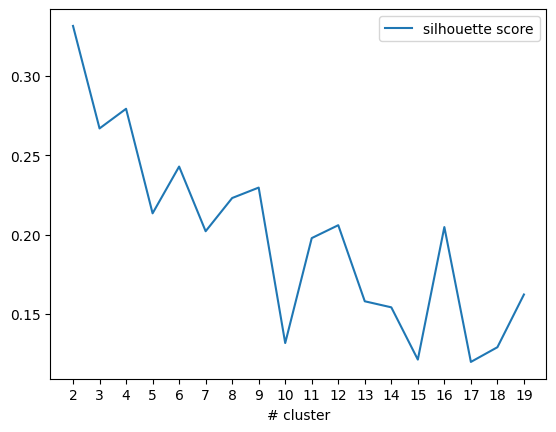

In [29]:
pd.DataFrame(scores).rename(
        columns={0:"# cluster", 1:"silhouette score"}
    ).sort_values(
        "# cluster"
    ).plot(x="# cluster", y="silhouette score")

plt.xticks(range(2, 20))

# Choosing the cluster count

In [30]:
CLUSTER_COUNT = 10
km = TimeSeriesKMeans(n_clusters=CLUSTER_COUNT, metric="dtw", n_jobs=2, n_init=5)
labels = km.fit_predict(X_train)

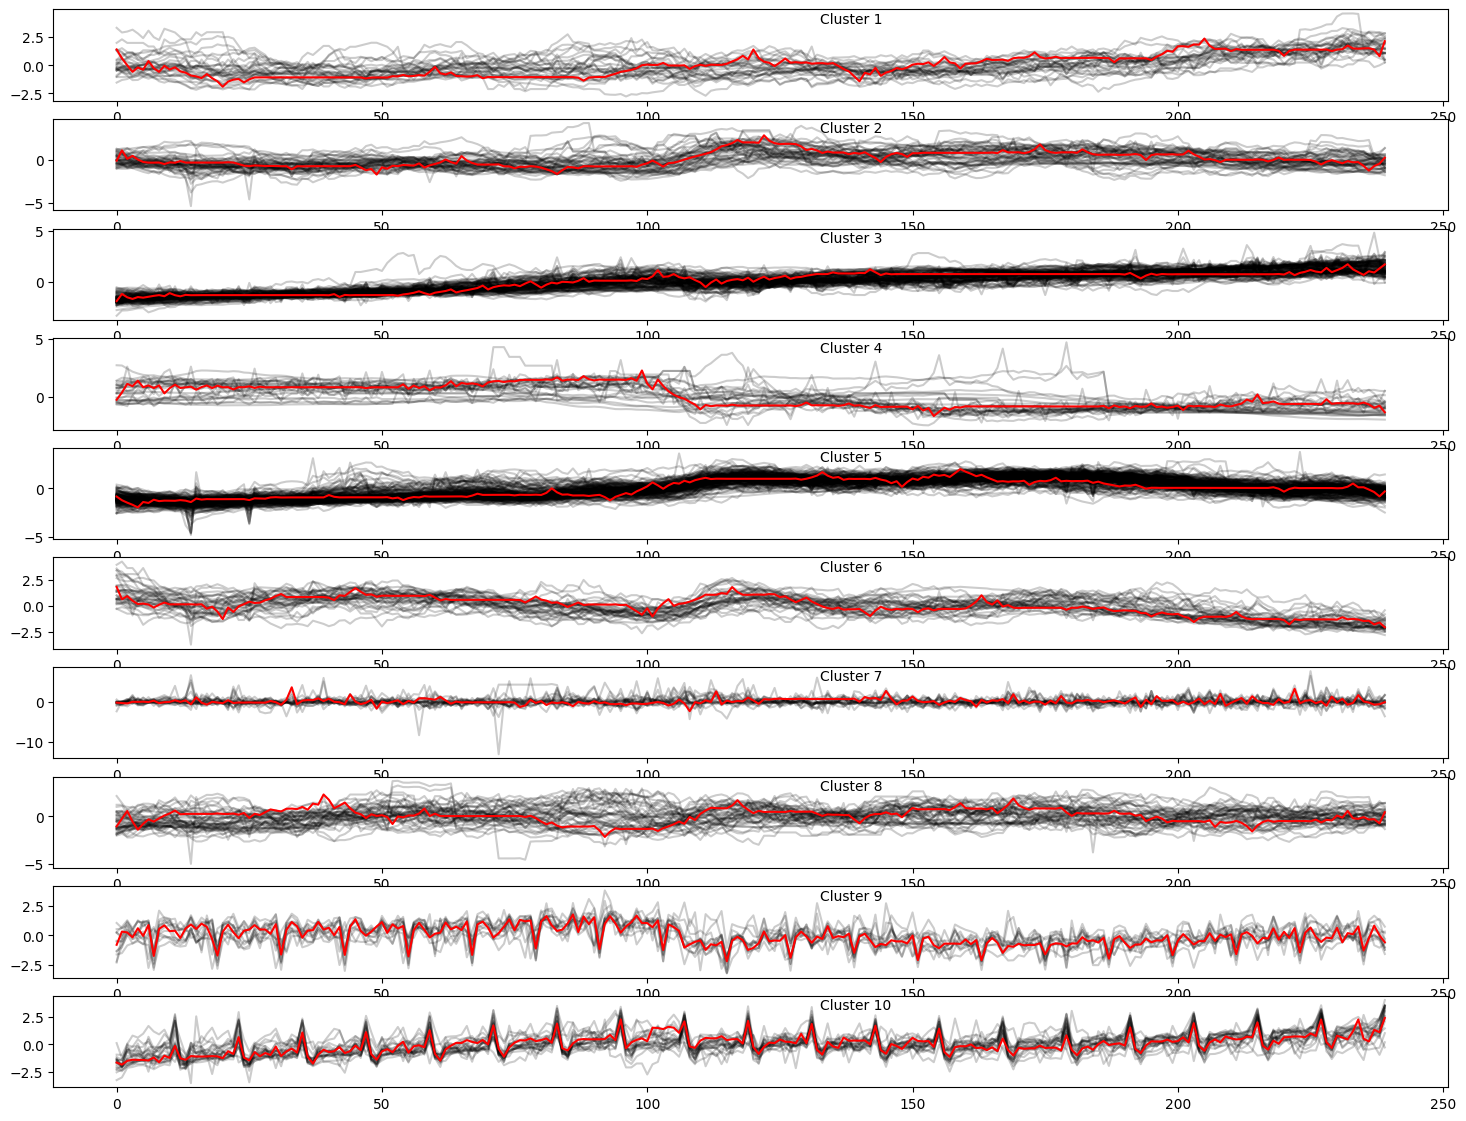

In [31]:
plt.figure(figsize=(18,14))

for yi in range(CLUSTER_COUNT):
    plt.subplot(CLUSTER_COUNT, 1, yi + 1)
    for xx in X_train[labels == yi]:
        plt.plot(xx.ravel(), "k-", alpha=0.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    # plt.xlim(0, 1000)
    # plt.ylim(-4, 4)
    plt.text(0.55, 0.85, "Cluster %d" % (yi + 1), transform=plt.gca().transAxes)


# Analyzing the redundant tokens in the time serie names of cluster

In [32]:
from tsclustering.text_processing import (parse_serie_name, get_dict_count,
                                          get_dict_freq, get_doc_dicts, 
                                          get_idf_scores, get_tfidf_scores)

In [33]:
# { i: column_name for i, column_name in enumerate(normalized_final_df.columns) }
# cluster_serie_indices = np.where(labels == i)[0]

column_names = np.array(normalized_final_df.columns)

cluster_sizes = []
names_by_cluster = []
series_by_cluster = []
cluster_tokens = []
corpus_tokens = set()

for i in range(CLUSTER_COUNT):
    cluster_series = X_train[labels == i]
    series_by_cluster.append(cluster_series)

    cluster_serie_names = column_names[labels == i]
    names_by_cluster.append(cluster_serie_names)

    cluster_size = len(cluster_series)
    cluster_sizes.append(cluster_size)

    tokens = sum([parse_serie_name(serie_name) for serie_name in cluster_serie_names],[])
    cluster_tokens.append(tokens)
    corpus_tokens.update(set(tokens))


In [34]:
# idf
cluster_dicts = get_doc_dicts(cluster_tokens)
idf_scores = get_idf_scores(corpus_tokens, cluster_dicts)

cluster_tdidfs = []

# tf-idf
for tokens in cluster_tokens:
    cluster_dict_counts = get_dict_count(tokens)
    cluster_dict_freqs = get_dict_freq(cluster_dict_counts)

    tfidf_scores = get_tfidf_scores(cluster_dict_freqs, idf_scores)
    cluster_tdidfs.append(tfidf_scores)
    

In [35]:
df = pd.DataFrame({
    "cluster": range(1, len(cluster_sizes)+1),
    "size":cluster_sizes,
    "series":[", ".join(list(get_dict_count(tokens).keys())[:5]) for tokens in cluster_tokens]
})
print(df.reset_index(drop=True).set_index(["cluster"]).to_markdown())

|   cluster |   size | series                                                                                                             |
|----------:|-------:|:-------------------------------------------------------------------------------------------------------------------|
|         1 |     28 | Défaillances, Unités légales, nombre cumulé sur 12 mois, Corse, (CVS-CJO)                                          |
|         2 |     44 | Défaillances, Unités légales, nombre cumulé sur 12 mois, Flux cumulés 12 mois glissants, Taux de chômage           |
|         3 |    112 | (CVS-CJO), Défaillances, Unités légales, nombre cumulé sur 12 mois, Indice de production industrielle              |
|         4 |     26 | (CVS-CJO), Indice de production industrielle, [hors bâtiment], Indice de ventes au détail, Taux de chômage         |
|         5 |    179 | Défaillances, Unités légales, nombre cumulé sur 12 mois, Construction, Information et communication                |
|         6 |     33

In [36]:
df = pd.DataFrame({
    "cluster": range(1, len(cluster_sizes)+1),
    "size":cluster_sizes,
    "series":[", ".join(list(tfidfs.keys())[:5]) for tfidfs in cluster_tdidfs]
})
print(df.reset_index(drop=True).set_index(["cluster"]).to_markdown())

|   cluster |   size | series                                                                                                                     |
|----------:|-------:|:---------------------------------------------------------------------------------------------------------------------------|
|         1 |     28 | Défaillances, nombre cumulé sur 12 mois, Corse, Indice de ventes au détail, Unités légales                                 |
|         2 |     44 | Défaillances, nombre cumulé sur 12 mois, Flux cumulés 12 mois glissants, Unités légales, (CVS)                             |
|         3 |    112 | (CVS-CJO), Unités légales, nombre cumulé sur 12 mois, [hors bâtiment], indice du prix à la production industrielle         |
|         4 |     26 | (CVS-CJO), [hors bâtiment], Indice de ventes au détail, (CVS), (CJO)                                                       |
|         5 |    179 | Défaillances, nombre cumulé sur 12 mois, Unités légales, Construction, (CVS-CJO)         

In [38]:
for names in names_by_cluster:
    print(names)

["Encours d'actions cotées, Valeur de marché (SEC 95)"
 'Encours notionnels de titres de dette à court terme, Sociétés non financières, Valeur nominale'
 "Encours d'actions cotées, Sociétés non financières, Valeur de marché (SEC 95)"
 "Encours d'actions cotées, Institutions financières non monétaires, Valeur de marché (SEC 95)"
 'Encours de titres de dette à court terme en euros, Sociétés non financières, Valeur nominale'
 'Allemagne, Indice de ventes au détail (CVS-CJO)'
 'Malte, Indice de ventes au détail (CVS-CJO)'
 'Pays-Bas, Indice de ventes au détail (CVS-CJO)'
 'Portugal, Indice de ventes au détail (CVS-CJO)'
 'Zone Euro, Indice de production industrielle [hors bâtiment] (CVS-CJO)'
 'Défaillances, Agriculture, sylviculture et pêche, Bourgogne-Franche-Comté, Unités légales, nombre cumulé sur 12 mois'
 'Défaillances, Corse-du-Sud, Unités légales, nombre cumulé sur 12 mois'
 'Défaillances, Haute-Corse, Unités légales, nombre cumulé sur 12 mois'
 'Défaillances, Seine-et-Marne, Unité